# BIT数据挖掘-频繁模式与关联规则挖掘

## 数据集：winemag-data-130k-v2

数据描述：

    Unnamed:0

(未命名)序号，对数据分析、数据挖掘无帮助，可删除

    country

The country that the wine is from 葡萄酒来源国家，即生产国

    description

葡萄酒描述

    designation

The vineyard within the winery where the grapes that made the wine are from 葡萄园名称

    points

The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)评分

    price

The cost for a bottle of the wine价格

    province

The province or state that the wine is from 省或州

    region_1

The wine growing area in a province or state 葡萄种植地区1

    region_2

Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank 葡萄种植地区2

    variety

The type of grapes used to make the wine 葡萄品种

    winery

The winery that made the wine 酿酒厂

在winemag-data-130k-v2数据集中又增加了三列信息：

    taster_name

品鉴师

    taster_twitter_handle

品鉴师twitter

    title

头衔

### 1. 数据读取

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymining import itemmining, assocrules

In [2]:
file_path_130 = "./wine/winemag-data-130k-v2.csv"
# 读取数据
df_130 = pd.read_csv(file_path_130)

In [3]:
# 因序号对数据挖掘没有帮助，因此删除该列数据
drop_columns_name_130 = df_130.columns[0]
df_130.drop(drop_columns_name_130, axis=1, inplace=True)

### 2. 数据预处理，转换成适合进行关联规则挖掘的形式

目的：对数据集进行处理，转换成适合进行关联规则挖掘的形式。
    
首先，winemag-data-130k-v2数据集中一共有13个属性，其中'description'属性不适合频繁模式与关联规则挖掘，因此我们把'description'属性去掉后还剩下12个属性。

然后，根据第一次互评作业知，该数据存在缺失数据，因此需要对缺失数据进行处理，处理方案是将缺失部分剔除。
    
接着，已知数据中'points'和'price'为数值属性，我们将其离散化处理，将其转化为字符串：对于points，其数值范围为80-100，将其分为80-85，85-90，90-95，95-100这4个阶段；对于price，根据第一次作业知其分布范围较大，最小为4美元，最大为3300美元，但是其主要的值都分布在100美元以内，所以我们根据第一次作业的直方图统计结果将其分为0-16，16-25，25-50，50-100，100+这5个阶段。
    
最后，查询Relim算法文档知，模型输入数据是一个list，因此需要把数据处理成相应格式，该list中一个元素代表一个样本数据，该变量名称为transactions。

In [4]:
# 去掉'description'属性
df_130.drop('description', inplace=True, axis=1)
# 输出属性名称
print(df_130.columns.tolist())

['country', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']


In [5]:
# 将缺失值剔除
df_130.dropna(how='any', inplace=True)
# 查看是否还存在缺失数据
df_130.isnull().sum()

country                  0
designation              0
points                   0
price                    0
province                 0
region_1                 0
region_2                 0
taster_name              0
taster_twitter_handle    0
title                    0
variety                  0
winery                   0
dtype: int64

In [6]:
# 将数据转换成适合进行关联规则挖掘的形式
# 处理数值属性：points和price
df_130['points'] = pd.cut(df_130.points, bins=[79, 85, 90, 95, 100], labels=['80~85', '85~90', '90~95', '95~100'])
df_130['price'] = pd.cut(df_130.price, bins=[0, 16, 25, 50, 100, 2013], labels=['0~16', '16~25', '25~50', '50~100', '100+'])
# 把数据整理成Relim模型输入格式：list
transactions = np.array(df_130).tolist()

In [7]:
# 展示部分适合进行关联规则挖掘的数据
for i in range(10):
    print(transactions[i])
    print(73 * '-')

['US', "Vintner's Reserve Wild Child Block", '85~90', '50~100', 'Oregon', 'Willamette Valley', 'Willamette Valley', 'Paul Gregutt', '@paulgwine\xa0', "Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley)", 'Pinot Noir', 'Sweet Cheeks']
-------------------------------------------------------------------------
['US', 'Mountain Cuvée', '85~90', '16~25', 'California', 'Napa Valley', 'Napa', 'Virginie Boone', '@vboone', 'Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley)', 'Cabernet Sauvignon', 'Kirkland Signature']
-------------------------------------------------------------------------
['US', 'Signature Selection', '85~90', '16~25', 'California', 'Paso Robles', 'Central Coast', 'Matt Kettmann', '@mattkettmann', 'Bianchi 2011 Signature Selection Merlot (Paso Robles)', 'Merlot', 'Bianchi']
-------------------------------------------------------------------------
['US', 'King Ridge Vineyard', '85~90', '50~100', 'California', 'Sonoma Coast'

### 3. 找出频繁模式

##### 挖掘频繁模式算法：Relim算法

##### Relim算法简介：
* 该算法是在FP-growth算法基础上提出的一种不需要候选项集的频繁项集挖掘算法，它具有算法结构简单，空间利用率高，易于实现等显著优点。该算法的主要思想和FP-growth相似，也是基于递归搜索(Recursive Exploration)，但是和FP-growth不同的是：Relim算法在运行时不必创建频繁模式树，而是通过建立一个事务链表组(transaction lists)来找出所有频繁项集。

##### Relim算法流程：
1. 扫描事务数据集D，找出频繁1项集和它们的支持度，并按支持度大小递增排列。然后，对于D中每个事务，执行如下操作后得到新的事物数据集D'：删除频繁1项集以外的元素，并按支持度大小递增排列元素。
2. 将D'转换成一个事务链表组TLs。该事务链表组中的各项事务链表TL保存着头元素相同的各事务的相关信息，并且接头元素支持度大小递增排列。
3. 按头元素支持度大小递增排列顺序，依次对TLs中的每个TL进行如下操作：
    * 递归地扫描该事务链表，找出频繁项集并输出。
    * 将该事务链表从TLs中删除，并创建以该事务链表头元素为前缀的事务链表组TLs'
    * 合并TLs和TLs'，得到新的事务链表组TLs。(TLs+TLs'—>TLs)  
4. 挖掘完最后一个事务链表后，结束频繁项集的挖掘。

In [8]:
# 调用pymining库函数来挖掘频繁模式
# 在数据集中挖掘出现次数大于100的频繁项集
relim_input = itemmining.get_relim_input(transactions)
report = itemmining.relim(relim_input, min_support=100)

In [9]:
# 对得到频繁模式进行展示、分析
# 对挖掘得到频繁模式排序
report_sort = sorted(report.items(), key=lambda item:item[1], reverse=True)

report_len = len(report_sort)
print('挖掘得到的频繁模式数量：{}'.format(report_len))
# 展示频繁模式前100项
# 展示结果：(item, number)对应挖掘得到的频繁模式的项目集，项目集出现频数
print('挖掘得到的频繁模式前100项，其展示形式为(item, number)，对应挖掘得到的频繁模式的项目集，项目集出现频数，展示结果如下：')
for item in report_sort[:100]:
    print(item)

挖掘得到的频繁模式数量：17555
挖掘得到的频繁模式前100项，其展示形式为(item, number)，对应挖掘得到的频繁模式的项目集，项目集出现频数，展示结果如下：
(frozenset({'US'}), 22387)
(frozenset({'California'}), 12900)
(frozenset({'California', 'US'}), 12900)
(frozenset({'85~90'}), 11811)
(frozenset({'85~90', 'US'}), 11811)
(frozenset({'25~50'}), 10829)
(frozenset({'25~50', 'US'}), 10829)
(frozenset({'90~95'}), 8631)
(frozenset({'90~95', 'US'}), 8631)
(frozenset({'85~90', 'California'}), 6453)
(frozenset({'85~90', 'California', 'US'}), 6453)
(frozenset({'@vboone'}), 6422)
(frozenset({'Virginie Boone', '@vboone'}), 6422)
(frozenset({'Virginie Boone', 'California', '@vboone'}), 6422)
(frozenset({'Virginie Boone', 'US', 'California', '@vboone'}), 6422)
(frozenset({'Virginie Boone', 'US', '@vboone'}), 6422)
(frozenset({'California', '@vboone'}), 6422)
(frozenset({'US', 'California', '@vboone'}), 6422)
(frozenset({'US', '@vboone'}), 6422)
(frozenset({'Virginie Boone'}), 6422)
(frozenset({'Virginie Boone', 'California'}), 6422)
(frozenset({'Virginie Boone', 'Ca

#### 我们在winemag-data-130k-v2数据集中出现次数大于100的频繁项集使用Relim算法找出来了，共计17555项

### 4. 导出关联规则，计算其支持度和置信度

因为数据集数据量过大，而且是多个地区的统计数据混合而成的，所以我们再用相对支持度来衡量是否频繁就不太合适（假如12w条数据中，美国的只有100条，那么我们如果将支持度设为0.1那么美国的数据将会被我们忽略），所以我们用出现的次数作为衡量标准，我们将最少出现次数度为100，最小支持度为0.5的关联规则挖掘出来

In [10]:
# 导出关联规则
rules = assocrules.mine_assoc_rules(report, min_support=100, min_confidence=0.5)

In [13]:
# 计算支持度和置信度，并输出出来
# 挖掘得到的关联规则有159217项，全部输出出来会导致文件过于庞大，因此只在界面中打印1000项，当然还可以自行设置print数量
print_count = 1000
count = 0
for item in rules:
    # 计算相对支持度
    sup = report[item[0]|item[1]] * 1.0 / report_len
    if count <= print_count:
        print("rules:\n{} ---> {} \nabsolute support:{}  support:{}  confidence:{}".format(str(item[0])[10:-1], str(item[1])[10:-1], item[2], round(sup, 4), round(item[3], 4)))
        print(72 * '-')
    count += 1

rules:
{'Dundee Hills', '@paulgwine\xa0', 'Oregon', 'Willamette Valley', '50~100', 'Pinot Noir', '90~95', 'US'} ---> {'Paul Gregutt'} 
absolute support:126  support:0.0072  confidence:1.0
------------------------------------------------------------------------
rules:
{'Dundee Hills', 'Oregon', 'Willamette Valley', '50~100', 'Pinot Noir', '90~95', 'US'} ---> {'Paul Gregutt', '@paulgwine\xa0'} 
absolute support:126  support:0.0072  confidence:1.0
------------------------------------------------------------------------
rules:
{'Willamette Valley', '50~100', 'Pinot Noir', '90~95', 'Dundee Hills', 'US'} ---> {'Paul Gregutt', 'Oregon', '@paulgwine\xa0'} 
absolute support:126  support:0.0072  confidence:1.0
------------------------------------------------------------------------
rules:
{'50~100', 'Pinot Noir', '90~95', 'Dundee Hills', 'US'} ---> {'Paul Gregutt', 'Oregon', 'Willamette Valley', '@paulgwine\xa0'} 
absolute support:126  support:0.0072  confidence:1.0
-----------------------------

------------------------------------------------------------------------
rules:
{'25~50', 'US', 'Chardonnay', '@vboone', 'Russian River Valley', 'California'} ---> {'Virginie Boone', '85~90', 'Sonoma'} 
absolute support:111  support:0.0063  confidence:0.5286
------------------------------------------------------------------------
rules:
{'25~50', 'Chardonnay', '@vboone', 'Russian River Valley', 'California'} ---> {'Virginie Boone', 'US', '85~90', 'Sonoma'} 
absolute support:111  support:0.0063  confidence:0.5286
------------------------------------------------------------------------
rules:
{'25~50', 'Chardonnay', '@vboone', 'Russian River Valley'} ---> {'Virginie Boone', '85~90', 'Sonoma', 'California', 'US'} 
absolute support:111  support:0.0063  confidence:0.5286
------------------------------------------------------------------------
rules:
{'25~50', 'Chardonnay', '@vboone', 'Russian River Valley', 'US'} ---> {'Virginie Boone', '85~90', 'California', 'Sonoma'} 
absolute support:111

### 5. 对规则进行评价

提升度Lift计算公式：
$$ Lift(A,B) = \frac {P(A\cup B)}{P(A) P(B)} $$
其中，如果Lift<1，则A的出现与B的出现是负相关，意味着一个出现可能导致另一个不出现；如果Lift>1，则A和B是正相关的，意味着每一个的出现都蕴涵另一个的出现；如果Lift=1，则A和B是独立的，它们之间没有相关性。

全置信度all_confidence计算公式：
$$all_{-}conf(A, B)=\frac{\sup (A \cup B)}{\max \{\sup (A), \sup (B)\}}=\min \{P(A | B), P(B | A)\}$$
其中$max\{sup(A), sup(B)\}$是A和B的最大支持度，因此$all_{-}conf(A, B)$又称两个与A和B相关的关联规则的最小置信度。

Kulczynski(Kulc)度量计算公式：
$$Kulc(A,B)=\frac{1}{2}(P(A|B) + P(B|A))$$
该计算公式可以看作两个置信度的平均值。

余弦度量计算公式：
$$\operatorname{cosine}(A, B)=\frac{P(A \cup B)}{\sqrt{P(A) \times P(B)}}=\frac{\sup (A \cup B)}{\sqrt{\sup (A) \times \sup (B)}}=\sqrt{P(A | B) \times P(B | A)}$$
余弦度量可以看作调和提升度量。

In [14]:
# 对规则评价，评价标准为Lift、all_confidence、Kulc、cosine，并输出出来
# 挖掘得到的关联规则有159217项，全部输出出来会导致文件过于庞大，因此只在界面中打印1000项，当然还可以自行设置print数量
# 得到的数据进行整理，方便后续可视化
result = [] # 对应item_1--->item_2，support, confidence, lift, all_confidence, kulc, cosine
print_count = 1000
count = 0
for item in rules:
    # 计算相对支持度
    sup = report[item[0]|item[1]] * 1.0 / report_len
    # 计算item_1支持度
    sup_1 = report[item[0]] * 1.0 / report_len
    # 计算item_2支持度
    sup_2 = report[item[1]] * 1.0 / report_len
    # Lift 度量
    lift = sup / (sup_1 * sup_2)
    # all_confidence 度量
    all_confidence = sup / max(sup_1, sup_2)
    # Kulc 度量
    kulc = (sup / sup_1 + sup / sup_2) / 2
    # cosine 度量
    cosine = sup / np.sqrt(sup_1 * sup_2)
    result.append([str(item[0])[10:-1] + "--->" + str(item[1])[10:-1], sup, item[3], lift, all_confidence, kulc, cosine])
    if count <= print_count:
        print("rules:\n{} ---> {} \nlift:{}  all_confidence:{}  kulc:{}  cosine:{}".format(str(item[0])[10:-1], str(item[1])[10:-1], round(lift, 4), round(all_confidence, 4), round(kulc, 4), round(cosine, 4)))
        print(72 * '-')
    count += 1

rules:
{'Dundee Hills', '@paulgwine\xa0', 'Oregon', 'Willamette Valley', '50~100', 'Pinot Noir', '90~95', 'US'} ---> {'Paul Gregutt'} 
lift:2.9312  all_confidence:0.021  kulc:0.5105  cosine:0.145
------------------------------------------------------------------------
rules:
{'Dundee Hills', 'Oregon', 'Willamette Valley', '50~100', 'Pinot Noir', '90~95', 'US'} ---> {'Paul Gregutt', '@paulgwine\xa0'} 
lift:2.9312  all_confidence:0.021  kulc:0.5105  cosine:0.145
------------------------------------------------------------------------
rules:
{'Willamette Valley', '50~100', 'Pinot Noir', '90~95', 'Dundee Hills', 'US'} ---> {'Paul Gregutt', 'Oregon', '@paulgwine\xa0'} 
lift:5.3004  all_confidence:0.038  kulc:0.519  cosine:0.195
------------------------------------------------------------------------
rules:
{'50~100', 'Pinot Noir', '90~95', 'Dundee Hills', 'US'} ---> {'Paul Gregutt', 'Oregon', 'Willamette Valley', '@paulgwine\xa0'} 
lift:6.8361  all_confidence:0.0491  kulc:0.5245  cosine:0.2

lift:7.1857  all_confidence:0.0913  kulc:0.447  cosine:0.2707
------------------------------------------------------------------------
rules:
{'Virginie Boone', 'Pinot Noir', '90~95', 'Sonoma Coast', 'California', 'Sonoma'} ---> {'US', '50~100', '@vboone'} 
lift:7.1857  all_confidence:0.0913  kulc:0.447  cosine:0.2707
------------------------------------------------------------------------
rules:
{'Virginie Boone', 'Sonoma Coast', 'Sonoma', '50~100', '90~95', 'California', 'US'} ---> {'Pinot Noir', '@vboone'} 
lift:10.4329  all_confidence:0.129  kulc:0.4769  cosine:0.3262
------------------------------------------------------------------------
rules:
{'Virginie Boone', '50~100', 'US', 'Sonoma Coast', 'California', 'Sonoma'} ---> {'Pinot Noir', '90~95', '@vboone'} 
lift:14.8309  all_confidence:0.2518  kulc:0.4262  cosine:0.3889
------------------------------------------------------------------------
rules:
{'Virginie Boone', '50~100', 'Sonoma', 'Sonoma Coast', 'California'} ---> {'US', 

### 6. 对挖掘结果进行分析

In [15]:
# 把result整理成DataFrame格式
res = pd.DataFrame(data=result, columns=['rule', 'support', 'confidence', 'lift', 'all_confidence', 'kulc', 'cosine'])
# 根据lift对数据降序排序
res_sort = res.sort_values(by=['lift'], ascending=False)
res_sort = res_sort.reset_index()
res_sort.drop(['index'], inplace=True, axis=1)

In [16]:
# 展示置信度最高的前20项关联规则
res_sort_confidence = res.sort_values(by=['confidence'], ascending=False)
res_sort_confidence.reset_index(inplace=True)
res_50_rule = np.array(res_sort_confidence.loc[:20, 'rule']).tolist()
for item in res_50_rule:
    print(item)

{'Dundee Hills', '@paulgwine\xa0', 'Oregon', 'Willamette Valley', '50~100', 'Pinot Noir', '90~95', 'US'}--->{'Paul Gregutt'}
{'Columbia Valley (WA)', 'Paul Gregutt', '25~50', '90~95', '@paulgwine\xa0'}--->{'Washington'}
{'Columbia Valley (WA)', 'Paul Gregutt', '90~95', '@paulgwine\xa0'}--->{'Washington', 'US'}
{'Columbia Valley (WA)', 'Paul Gregutt', '90~95', 'Washington', '@paulgwine\xa0'}--->{'US'}
{'Columbia Valley (WA)', '@paulgwine\xa0', '90~95', 'US'}--->{'Paul Gregutt', 'Washington'}
{'Columbia Valley (WA)', '90~95', '@paulgwine\xa0'}--->{'Paul Gregutt', 'Washington', 'US'}
{'Columbia Valley (WA)', '@paulgwine\xa0', '90~95', 'Washington'}--->{'Paul Gregutt', 'US'}
{'Columbia Valley (WA)', 'US', '90~95', 'Washington', '@paulgwine\xa0'}--->{'Paul Gregutt'}
{'Columbia Valley (WA)', 'Paul Gregutt', '25~50', '90~95', 'Washington'}--->{'@paulgwine\xa0'}
{'Columbia Valley (WA)', 'Paul Gregutt', '25~50', '90~95'}--->{'@paulgwine\xa0', 'Washington'}
{'Columbia Valley (WA)', '25~50', '90~

根据上述挖掘结果，可以挖掘出一些关于葡萄酒种类与原产地之间、以及品酒师与酒类原产地之间的关系。

例如，Cabernet Sauvignon(卡百内红葡萄酒)很有可能来源于US(美国)；Pinot Noir（黑皮诺葡萄酒）很有可能来源于California（加利福尼亚州）；Virginie Boone（人名）经常品鉴California产的葡萄酒。

In [17]:
low_count = 0
mid_count = 0
high_count = 0
for i in range(len(res)):
    if res.iat[i, 3] > 1.0:
        high_count += 1
    elif res.iat[i, 3] < 1.0:
        low_count += 1
    else:
        mid_count +=1
print('挖掘得到的关联规则一共有{}个，Lift > 1的关联规则有{}个，Lift < 1的关联规则有{}个，Lift = 1的关联规则有{}个。'.format(len(res), high_count, low_count, mid_count))

挖掘得到的关联规则一共有159217个，Lift > 1的关联规则有144501个，Lift < 1的关联规则有14716个，Lift = 1的关联规则有0个。


该数据总共挖掘出了159217个关联规则，其中关联规则评价指标Lift>1的关联规则有144501个，占比90.76%，Lift>1表明A和B是正相关的，意味着每一个的出现都蕴涵另一个的出现；而Lift<1的关联规则有14716个，占比大约10%，Lift<1表面A和B是负相关，意味着一个出现可能导致另一个不出现。

因此，根据上述数据可以得知，关联规则的Lift大部分都大于1，所以从提升度的角度来看，挖掘得到的关联规则是有很大的相关性。

### 7. 可视化关联规则

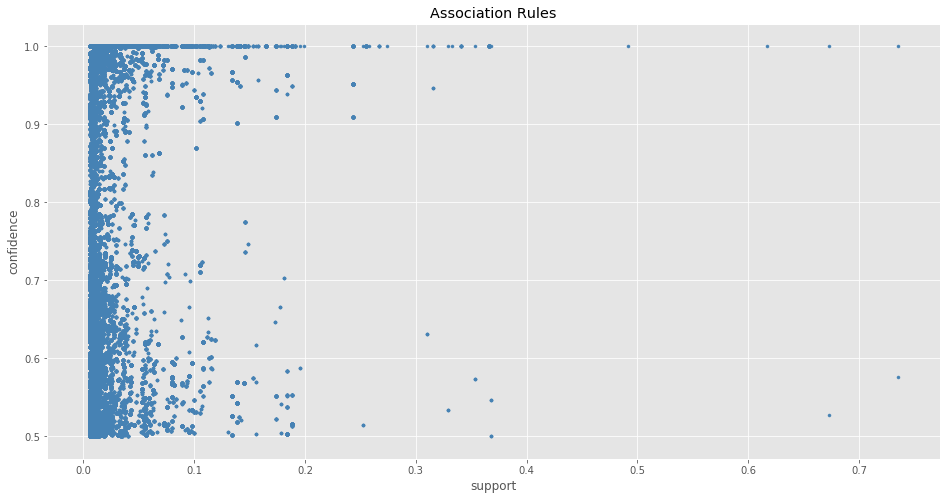

In [18]:
# 绘制support、confidence散点图
plt.figure(figsize=(16,8))
plt.style.use('ggplot')

plt.scatter(x=res['support'], y=res['confidence'], marker='.',color = 'steelblue')

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

结果分析：从散点图中可以看出，大部分关联规则的支持度分布在0到0.1之间，置信度分布在0.5到1之间。

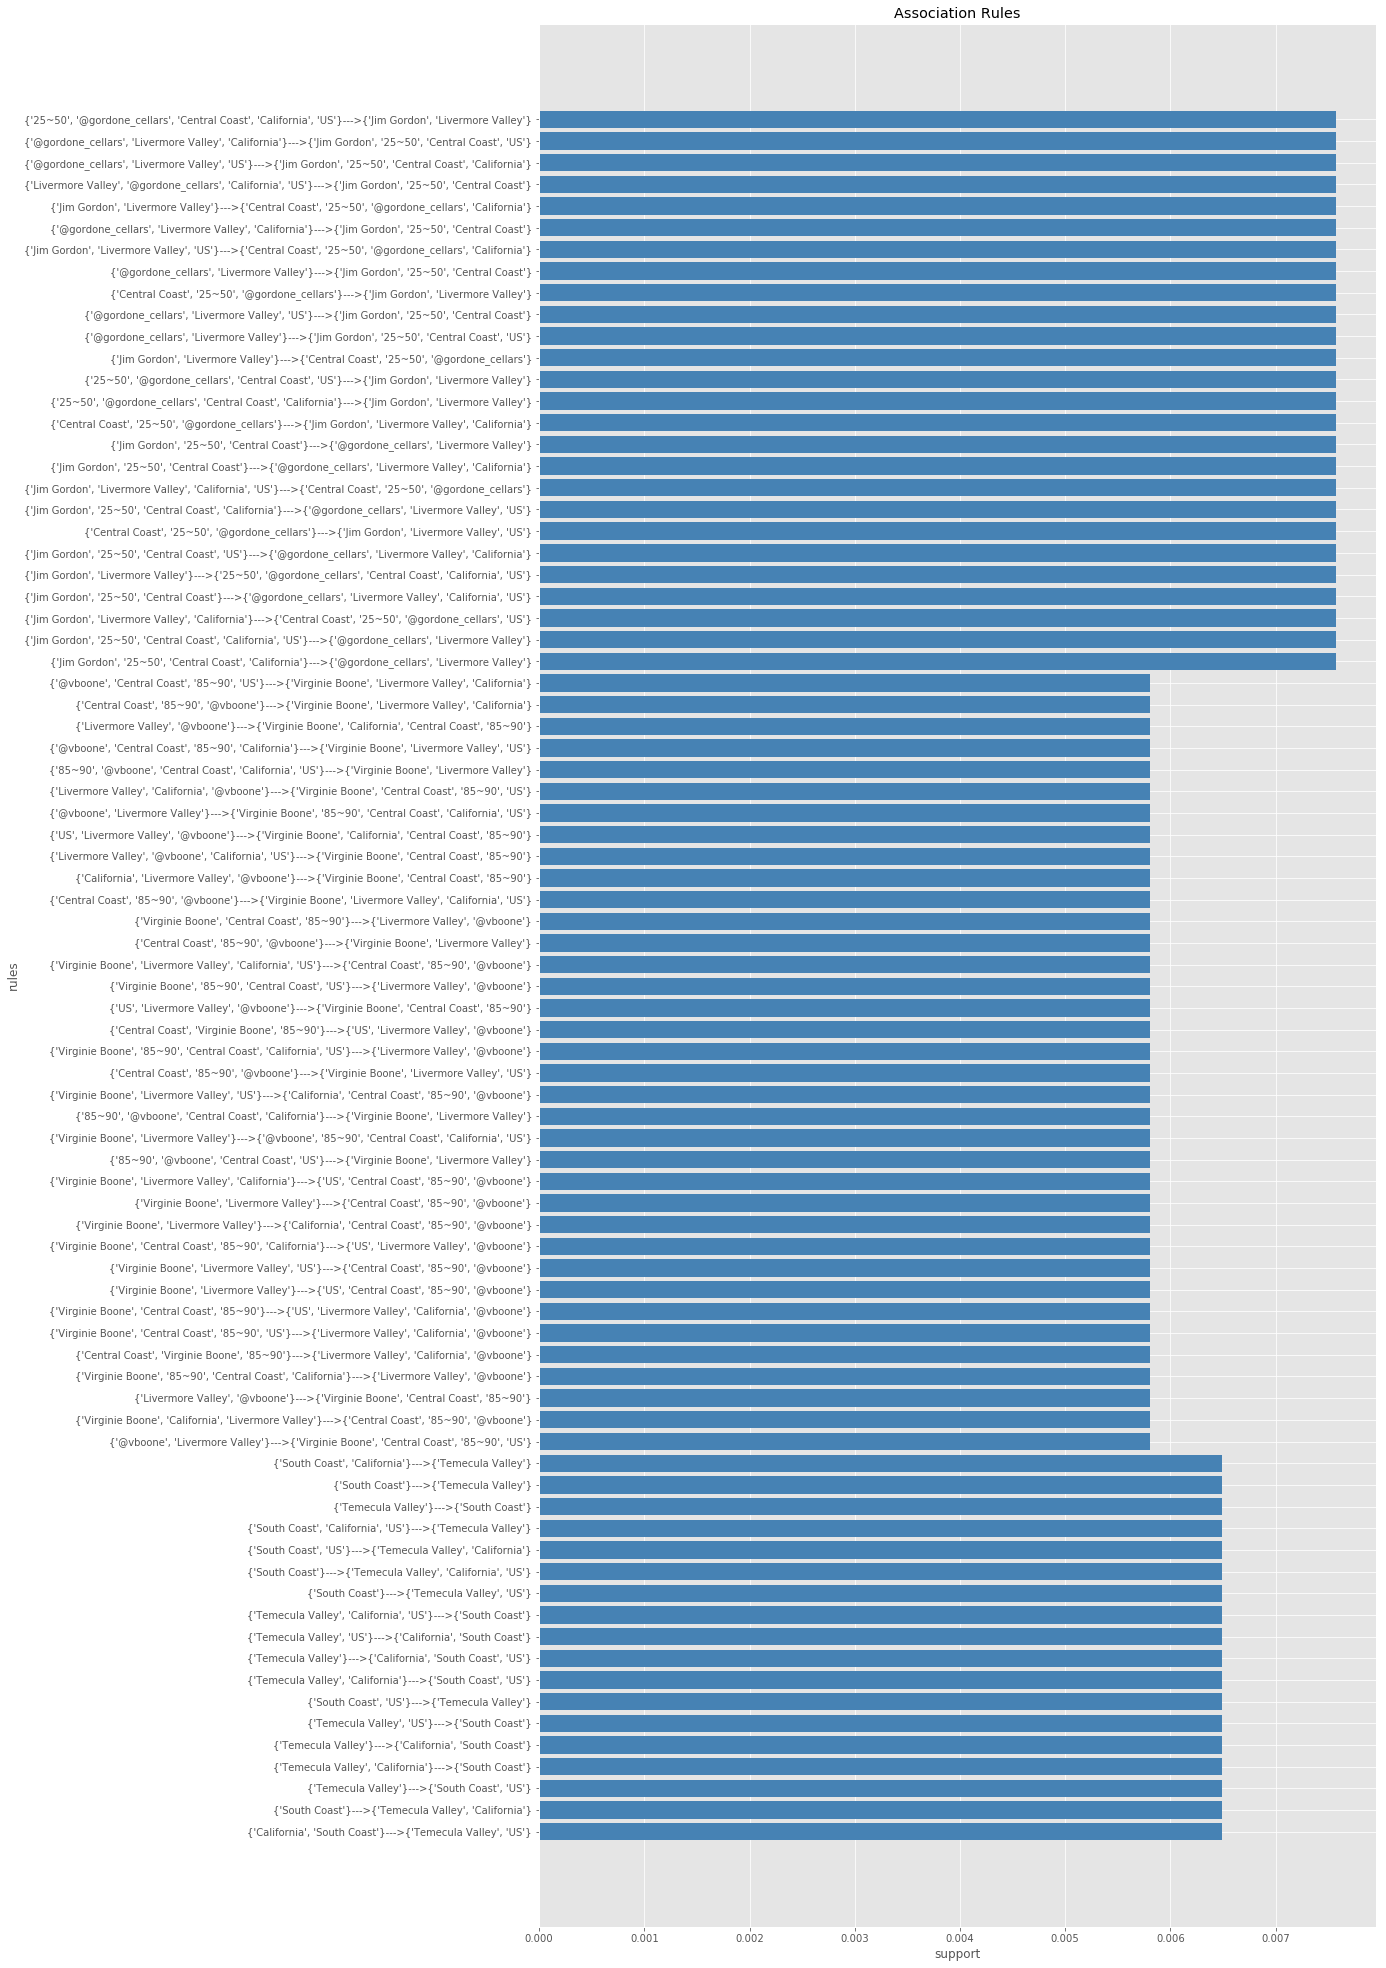

In [19]:
# 通过条形图来可视化关联规则的对应的支持度，选择排名靠前80进行展示
plt.figure(figsize=(15, 35))
plt.style.use('ggplot')

x = [i for i in range(80)]
y = res_sort.loc[:79, 'support'].tolist()
xticks = res_sort.loc[:79, 'rule'].tolist()
plt.yticks(x, xticks)
plt.barh(x, y, color = 'steelblue')

plt.title('Association Rules')
plt.ylabel('rules')
plt.xlabel('support')
plt.show()

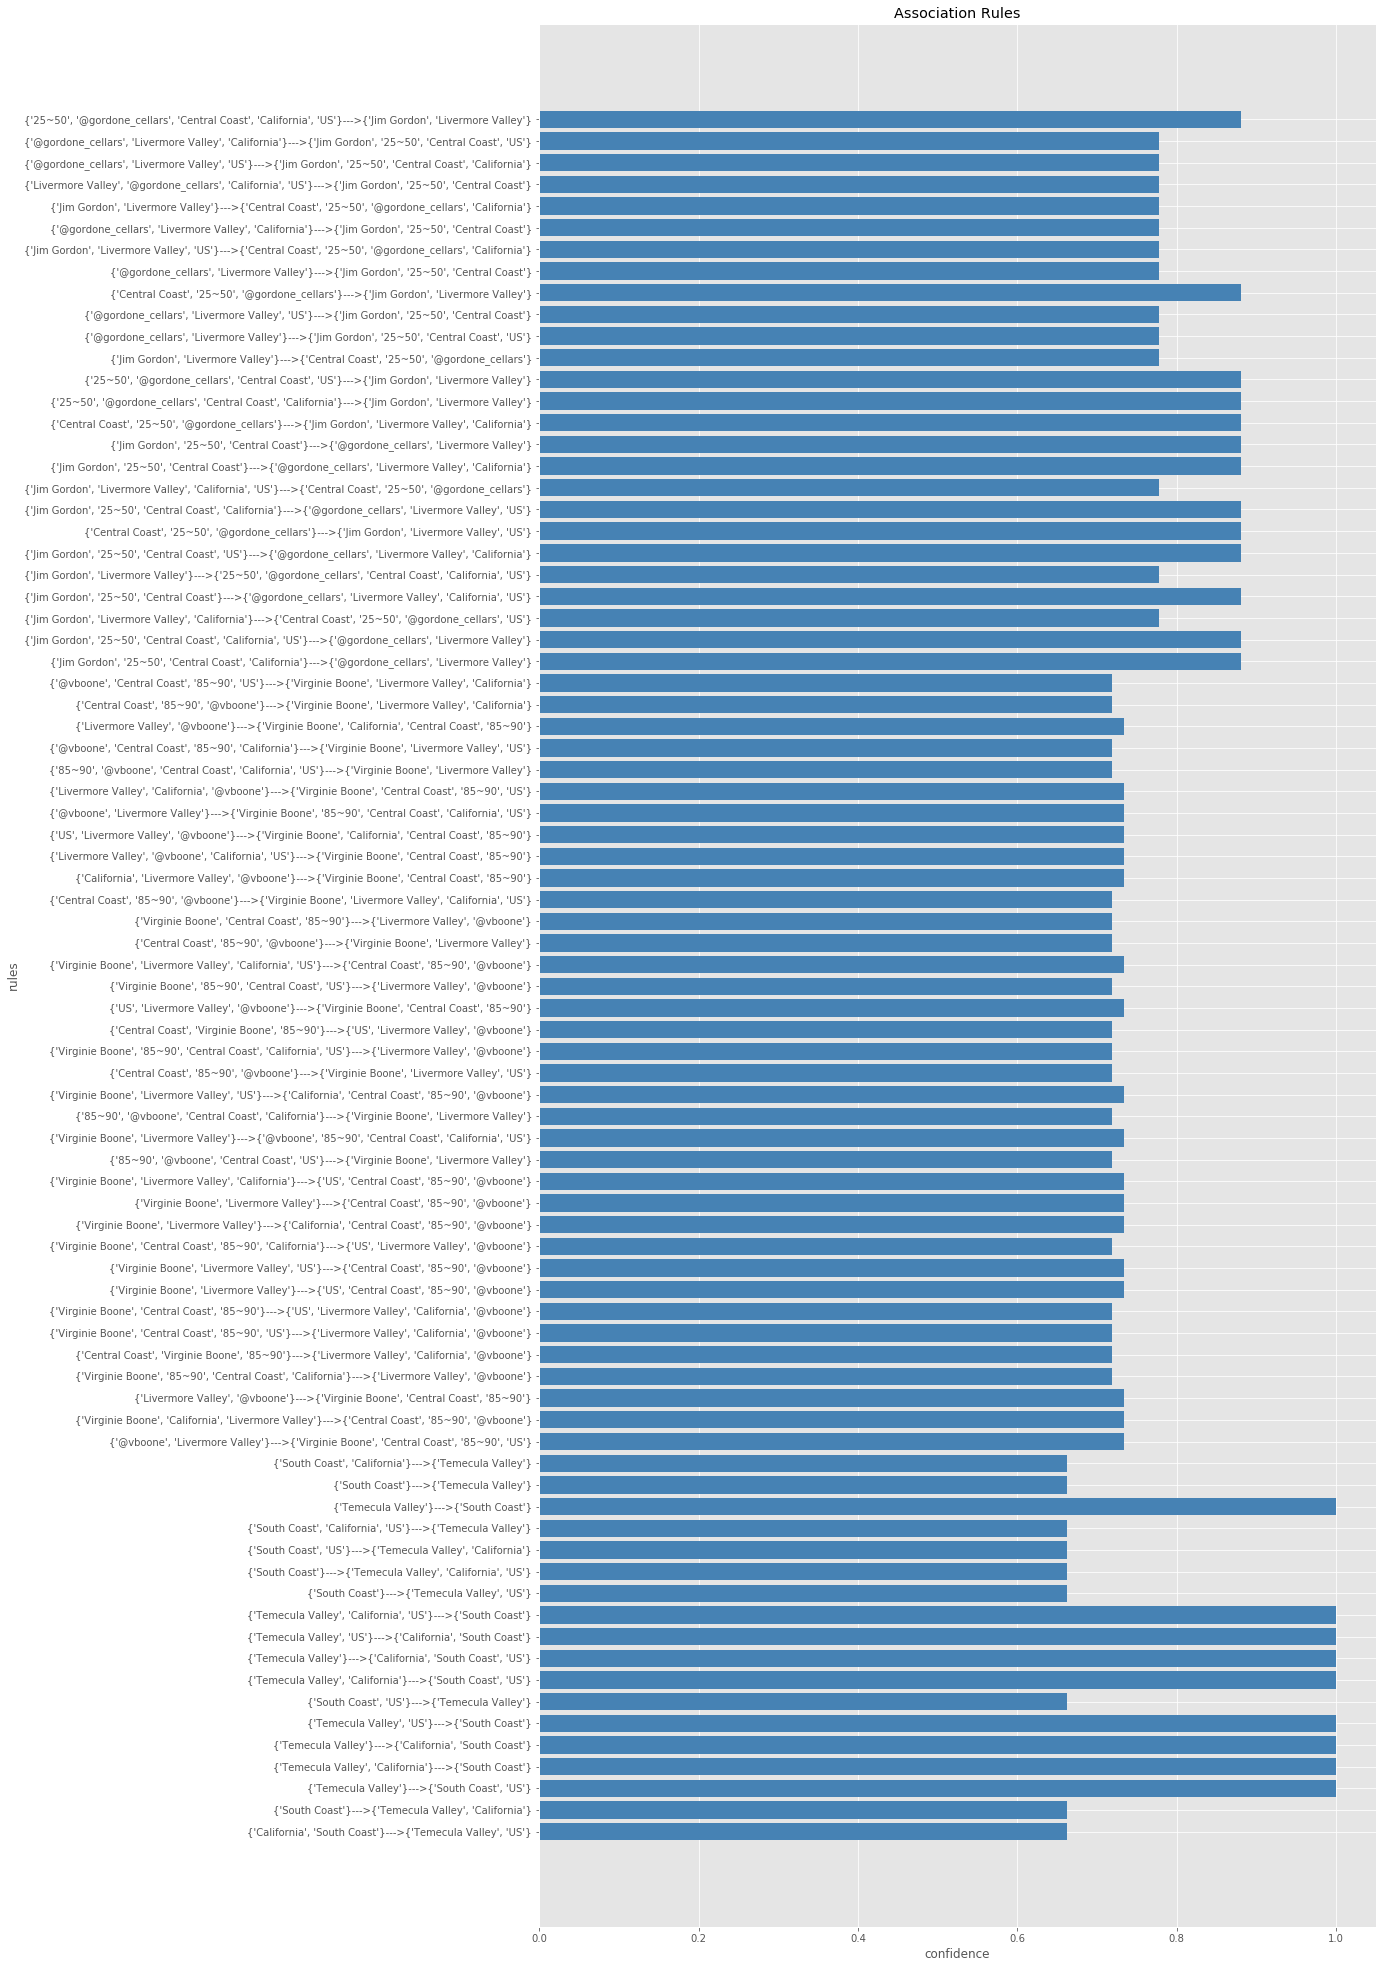

In [20]:
# 通过条形图来可视化关联规则的对应的置信度，选择排名靠前80进行展示
plt.figure(figsize=(15, 35))
plt.style.use('ggplot')

x = [i for i in range(80)]
y = res_sort.loc[:79, 'confidence'].tolist()
xticks = res_sort.loc[:79, 'rule'].tolist()
plt.yticks(x, xticks)
plt.barh(x, y, color = 'steelblue')

plt.title('Association Rules')
plt.ylabel('rules')
plt.xlabel('confidence')
plt.show()

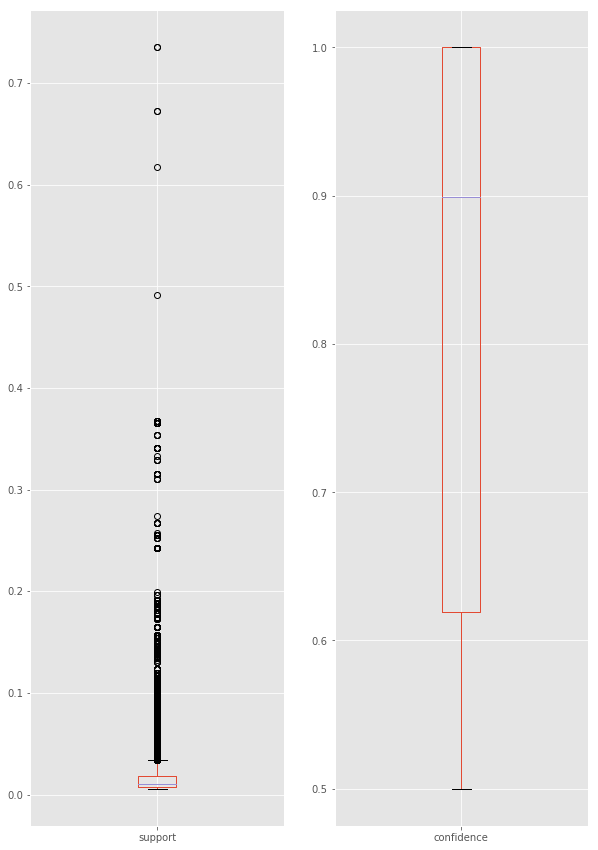

In [21]:
# 通过盒图查看关联规则的支持度、置信度分布情况
plt.subplot(1, 2, 1)
res["support"].plot.box(figsize=(10, 15))
plt.subplot(1, 2, 2)
res["confidence"].plot.box(figsize=(10, 15))
plt.show()

结果分析：通过盒图再次印证关联规则的支持度分布集中在0-0.1，置信度分布集中在0.5-1

## 数据集：winemag-data_first150k

### 1. 数据读取

In [22]:
file_path_150 = "./wine/winemag-data_first150k.csv"
# 读取数据
df_150 = pd.read_csv(file_path_150)

In [23]:
# 因序号对数据挖掘没有帮助，因此删除该列数据
drop_columns_name_150 = df_150.columns[0]
df_150.drop(drop_columns_name_150, axis=1, inplace=True)

### 2. 数据预处理，转换成适合进行关联规则挖掘的形式

In [24]:
# 去掉'description'属性
df_150.drop('description', inplace=True, axis=1)
# 输出属性名称
print(df_150.columns.tolist())

['country', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety', 'winery']


In [25]:
# 将缺失值剔除
df_150.dropna(how='any', inplace=True)
# 查看是否还存在缺失数据
df_150.isnull().sum()

country        0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
variety        0
winery         0
dtype: int64

In [26]:
# 将数据转换成适合进行关联规则挖掘的形式
# 处理数值属性：points和price
df_150['points'] = pd.cut(df_150.points, bins=[79, 85, 90, 95, 100], labels=['80~85', '85~90', '90~95', '95~100'])
df_150['price'] = pd.cut(df_150.price, bins=[0, 16, 25, 50, 100, 2013], labels=['0~16', '16~25', '25~50', '50~100', '100+'])
# 把数据整理成Relim模型输入格式：list
transactions = np.array(df_150).tolist()

In [27]:
# 展示部分适合进行关联规则挖掘的数据
for i in range(10):
    print(transactions[i])
    print(73 * '-')

['US', "Martha's Vineyard", '95~100', '100+', 'California', 'Napa Valley', 'Napa', 'Cabernet Sauvignon', 'Heitz']
-------------------------------------------------------------------------
['US', 'Special Selected Late Harvest', '95~100', '50~100', 'California', 'Knights Valley', 'Sonoma', 'Sauvignon Blanc', 'Macauley']
-------------------------------------------------------------------------
['US', 'Reserve', '95~100', '50~100', 'Oregon', 'Willamette Valley', 'Willamette Valley', 'Pinot Noir', 'Ponzi']
-------------------------------------------------------------------------
['US', 'Silice', '90~95', '50~100', 'Oregon', 'Chehalem Mountains', 'Willamette Valley', 'Pinot Noir', 'Bergström']
-------------------------------------------------------------------------
['US', "Gap's Crown Vineyard", '90~95', '50~100', 'California', 'Sonoma Coast', 'Sonoma', 'Pinot Noir', 'Blue Farm']
-------------------------------------------------------------------------
['US', 'Estate Vineyard Wadensvil Blo

### 3. 找出频繁模式

In [28]:
# 调用pymining库函数来挖掘频繁模式
# 在数据集中挖掘出现次数大于100的频繁项集
relim_input = itemmining.get_relim_input(transactions)
report = itemmining.relim(relim_input, min_support=100)

In [29]:
# 对得到频繁模式进行展示、分析
# 对挖掘得到频繁模式排序
report_sort = sorted(report.items(), key=lambda item:item[1], reverse=True)

report_len = len(report_sort)
print('挖掘得到的频繁模式数量：{}'.format(report_len))
# 展示频繁模式前100项
# 展示结果：(item, number)对应挖掘得到的频繁模式的项目集，项目集出现频数
print('挖掘得到的频繁模式前100项，其展示形式为(item, number)，对应挖掘得到的频繁模式的项目集，项目集出现频数，展示结果如下：')
for item in report_sort[:100]:
    print(item)

挖掘得到的频繁模式数量：7931
挖掘得到的频繁模式前100项，其展示形式为(item, number)，对应挖掘得到的频繁模式的项目集，项目集出现频数，展示结果如下：
(frozenset({'US'}), 39241)
(frozenset({'California'}), 28557)
(frozenset({'California', 'US'}), 28557)
(frozenset({'85~90'}), 19694)
(frozenset({'85~90', 'US'}), 19694)
(frozenset({'25~50'}), 18305)
(frozenset({'25~50', 'US'}), 18305)
(frozenset({'25~50', 'California'}), 13461)
(frozenset({'25~50', 'California', 'US'}), 13461)
(frozenset({'85~90', 'California'}), 13401)
(frozenset({'85~90', 'California', 'US'}), 13401)
(frozenset({'90~95'}), 10653)
(frozenset({'90~95', 'US'}), 10653)
(frozenset({'25~50', '85~90'}), 9678)
(frozenset({'25~50', '85~90', 'US'}), 9678)
(frozenset({'16~25'}), 9227)
(frozenset({'16~25', 'US'}), 9227)
(frozenset({'Central Coast'}), 9150)
(frozenset({'Central Coast', 'California'}), 9150)
(frozenset({'Central Coast', 'California', 'US'}), 9150)
(frozenset({'Central Coast', 'US'}), 9150)
(frozenset({'80~85'}), 8444)
(frozenset({'80~85', 'US'}), 8444)
(frozenset({'90~95', 'Califo

#### 我们在winemag-data_first150k数据集中出现次数大于100的频繁项集使用Relim算法找出来了，共计7931项

### 4. 导出关联规则，计算其支持度和置信度

In [30]:
# 导出关联规则
rules = assocrules.mine_assoc_rules(report, min_support=100, min_confidence=0.5)

In [31]:
# 计算支持度和置信度，并输出出来
# 挖掘得到的关联规则有29869项，全部输出出来会导致文件过于庞大，因此只在界面中打印1000项，当然还可以自行设置print数量
print_count = 1000
count = 0
for item in rules:
    # 计算相对支持度
    sup = report[item[0]|item[1]] * 1.0 / report_len
    if count <= print_count:
        print("rules:\n{} ---> {} \nabsolute support:{}  support:{}  confidence:{}".format(str(item[0])[10:-1], str(item[1])[10:-1], item[2], round(sup, 4), round(item[3], 4)))
        print(72 * '-')
    count += 1

rules:
{'50~100', '90~95', 'Napa', 'California', 'Rutherford', 'US'} ---> {'Cabernet Sauvignon'} 
absolute support:100  support:0.0126  confidence:0.9091
------------------------------------------------------------------------
rules:
{'Rutherford', '90~95', 'Napa', 'California', 'US'} ---> {'Cabernet Sauvignon', '50~100'} 
absolute support:100  support:0.0126  confidence:0.5714
------------------------------------------------------------------------
rules:
{'90~95', 'California', 'Rutherford', 'US'} ---> {'Napa', 'Cabernet Sauvignon', '50~100'} 
absolute support:100  support:0.0126  confidence:0.5714
------------------------------------------------------------------------
rules:
{'Rutherford', '90~95', 'US'} ---> {'Napa', 'Cabernet Sauvignon', '50~100', 'California'} 
absolute support:100  support:0.0126  confidence:0.5714
------------------------------------------------------------------------
rules:
{'90~95', 'Rutherford'} ---> {'Napa', 'Cabernet Sauvignon', '50~100', 'California', '

rules:
{'Pinot Noir', '90~95', 'Russian River Valley', 'California'} ---> {'50~100', 'Sonoma', 'US'} 
absolute support:292  support:0.0368  confidence:0.5168
------------------------------------------------------------------------
rules:
{'Russian River Valley', 'Pinot Noir', '90~95'} ---> {'50~100', 'California', 'Sonoma', 'US'} 
absolute support:292  support:0.0368  confidence:0.5168
------------------------------------------------------------------------
rules:
{'Pinot Noir', '90~95', 'Russian River Valley', 'Sonoma'} ---> {'50~100', 'California', 'US'} 
absolute support:292  support:0.0368  confidence:0.5168
------------------------------------------------------------------------
rules:
{'Pinot Noir', '90~95', 'Sonoma', 'Russian River Valley', 'US'} ---> {'50~100', 'California'} 
absolute support:292  support:0.0368  confidence:0.5168
------------------------------------------------------------------------
rules:
{'US', 'Pinot Noir', '90~95', 'Russian River Valley'} ---> {'50~100',

### 5. 对规则进行评价

In [32]:
# 对规则评价，评价标准为Lift、all_confidence、Kulc、cosine，并输出出来
# 挖掘得到的关联规则有29869项，全部输出出来会导致文件过于庞大，因此只在界面中打印1000项，当然还可以自行设置print数量
print_count = 1000
count = 0
# 得到的数据进行整理，方便后续可视化
result = [] # 对应item_1--->item_2，support, confidence, lift, all_confidence, kulc, cosine
for item in rules:
    # 计算相对支持度
    sup = report[item[0]|item[1]] * 1.0 / report_len
    # 计算item_1支持度
    sup_1 = report[item[0]] * 1.0 / report_len
    # 计算item_2支持度
    sup_2 = report[item[1]] * 1.0 / report_len
    # Lift 度量
    lift = sup / (sup_1 * sup_2)
    # all_confidence 度量
    all_confidence = sup / max(sup_1, sup_2)
    # Kulc 度量
    kulc = (sup / sup_1 + sup / sup_2) / 2
    # cosine 度量
    cosine = sup / np.sqrt(sup_1 * sup_2)
    result.append([str(item[0])[10:-1] + "--->" + str(item[1])[10:-1], sup, item[3], lift, all_confidence, kulc, cosine])
    if count <= print_count:
        print("rules:\n{} ---> {} \nlift:{}  all_confidence:{}  kulc:{}  cosine:{}".format(str(item[0])[10:-1], str(item[1])[10:-1], round(lift, 4), round(all_confidence, 4), round(kulc, 4), round(cosine, 4)))
        print(72 * '-')
    count += 1

rules:
{'50~100', '90~95', 'Napa', 'California', 'Rutherford', 'US'} ---> {'Cabernet Sauvignon'} 
lift:1.4726  all_confidence:0.0204  kulc:0.4648  cosine:0.1363
------------------------------------------------------------------------
rules:
{'Rutherford', '90~95', 'Napa', 'California', 'US'} ---> {'Cabernet Sauvignon', '50~100'} 
lift:2.6441  all_confidence:0.0583  kulc:0.3149  cosine:0.1826
------------------------------------------------------------------------
rules:
{'90~95', 'California', 'Rutherford', 'US'} ---> {'Napa', 'Cabernet Sauvignon', '50~100'} 
lift:3.7424  all_confidence:0.0826  kulc:0.327  cosine:0.2172
------------------------------------------------------------------------
rules:
{'Rutherford', '90~95', 'US'} ---> {'Napa', 'Cabernet Sauvignon', '50~100', 'California'} 
lift:3.7424  all_confidence:0.0826  kulc:0.327  cosine:0.2172
------------------------------------------------------------------------
rules:
{'90~95', 'Rutherford'} ---> {'Napa', 'Cabernet Sauvignon',

------------------------------------------------------------------------
rules:
{'Sta. Rita Hills', '50~100', '90~95'} ---> {'Pinot Noir', 'Central Coast', 'California', 'US'} 
lift:3.0842  all_confidence:0.0541  kulc:0.4803  cosine:0.2214
------------------------------------------------------------------------
rules:
{'Sta. Rita Hills', '50~100', '90~95', 'California'} ---> {'Pinot Noir', 'Central Coast', 'US'} 
lift:3.0842  all_confidence:0.0541  kulc:0.4803  cosine:0.2214
------------------------------------------------------------------------
rules:
{'Sta. Rita Hills', '50~100', '90~95', 'Central Coast', 'US'} ---> {'Pinot Noir', 'California'} 
lift:1.3233  all_confidence:0.0232  kulc:0.4648  cosine:0.145
------------------------------------------------------------------------
rules:
{'Sta. Rita Hills', '50~100', '90~95', 'Central Coast'} ---> {'Pinot Noir', 'California', 'US'} 
lift:1.3233  all_confidence:0.0232  kulc:0.4648  cosine:0.145
------------------------------------------

lift:0.2333  all_confidence:0.0106  kulc:0.295  cosine:0.0782
------------------------------------------------------------------------
rules:
{'25~50', 'Napa Valley', 'Cabernet Sauvignon', 'Napa', 'US'} ---> {'85~90', 'California'} 
lift:0.3429  all_confidence:0.0155  kulc:0.2975  cosine:0.0948
------------------------------------------------------------------------
rules:
{'25~50', 'Napa Valley', 'Cabernet Sauvignon', 'Napa'} ---> {'85~90', 'California', 'US'} 
lift:0.3429  all_confidence:0.0155  kulc:0.2975  cosine:0.0948
------------------------------------------------------------------------
rules:
{'25~50', 'Napa Valley', 'Cabernet Sauvignon', 'Napa', 'California'} ---> {'85~90', 'US'} 
lift:0.2333  all_confidence:0.0106  kulc:0.295  cosine:0.0782
------------------------------------------------------------------------
rules:
{'25~50', 'Napa Valley', 'Cabernet Sauvignon', 'Napa', '85~90', 'US'} ---> {'California'} 
lift:0.2777  all_confidence:0.0073  kulc:0.5036  cosine:0.0853
---

### 6. 对挖掘结果进行分析

In [33]:
# 把result整理成DataFrame格式
res = pd.DataFrame(data=result, columns=['rule', 'support', 'confidence', 'lift', 'all_confidence', 'kulc', 'cosine'])
# 根据lift对数据降序排序
res_sort = res.sort_values(by=['lift'], ascending=False)
res_sort = res_sort.reset_index()
res_sort.drop(['index'], inplace=True, axis=1)

In [34]:
# 展示置信度最高的前20项关联规则
res_sort_confidence = res.sort_values(by=['confidence'], ascending=False)
res_sort_confidence.reset_index(inplace=True)
res_50_rule = np.array(res_sort_confidence.loc[:20, 'rule']).tolist()
for item in res_50_rule:
    print(item)

{'California'}--->{'US'}
{'Red Mountain', '85~90'}--->{'Columbia Valley', 'Washington'}
{'16~25', 'California', 'Sonoma Valley'}--->{'Sonoma', 'US'}
{'US', '16~25', 'Sonoma Valley', 'Sonoma'}--->{'California'}
{'16~25', 'Sonoma Valley', 'US'}--->{'California', 'Sonoma'}
{'US', '16~25', 'Sonoma Valley', 'California'}--->{'Sonoma'}
{'90~95', 'Sonoma Valley', 'California', 'Sonoma'}--->{'US'}
{'90~95', 'Sonoma Valley', 'Sonoma'}--->{'California', 'US'}
{'90~95', 'Sonoma Valley'}--->{'Sonoma', 'California', 'US'}
{'California', '90~95', 'Sonoma Valley'}--->{'Sonoma', 'US'}
{'US', '90~95', 'Sonoma Valley', 'Sonoma'}--->{'California'}
{'90~95', 'Sonoma Valley', 'US'}--->{'California', 'Sonoma'}
{'US', '90~95', 'Sonoma Valley', 'California'}--->{'Sonoma'}
{'Red Mountain', '85~90', 'Columbia Valley'}--->{'Washington'}
{'Anderson Valley', '90~95', 'US'}--->{'California'}
{'25~50', 'Washington', 'Red Mountain'}--->{'Columbia Valley'}
{'25~50', 'Red Mountain'}--->{'Columbia Valley', 'Washington'}

根据上述挖掘结果，可以挖掘出一些关于葡萄酒种类与原产地之间的关系。

例如，Cabernet Sauvignon(卡百内红葡萄酒)很有可能来源于US(美国)；Pinot Noir（黑皮诺葡萄酒）很有可能来源于California（加利福尼亚州）。

In [35]:
low_count = 0
mid_count = 0
high_count = 0
for i in range(len(res)):
    if res.iat[i, 3] > 1.0:
        high_count += 1
    elif res.iat[i, 3] < 1.0:
        low_count += 1
    else:
        mid_count +=1
print('挖掘得到的关联规则一共有{}个，Lift > 1的关联规则有{}个，Lift < 1的关联规则有{}个，Lift = 1的关联规则有{}个。'.format(len(res), high_count, low_count, mid_count))

挖掘得到的关联规则一共有29869个，Lift > 1的关联规则有12120个，Lift < 1的关联规则有17749个，Lift = 1的关联规则有0个。


该数据总共挖掘出了29869个关联规则，其中关联规则评价指标Lift>1的关联规则有12120个，占比40.57%，Lift>1表明A和B是正相关的，意味着每一个的出现都蕴涵另一个的出现；而Lift<1的关联规则有17749个，占比大约59.42%，Lift<1表面A和B是负相关，意味着一个出现可能导致另一个不出现。

因此，根据上述数据可以得知，关联规则的Lift只有40%大于1，所以从提升度的角度来看，挖掘得到的关联规则只有40%才正相关。

### 7. 可视化关联规则

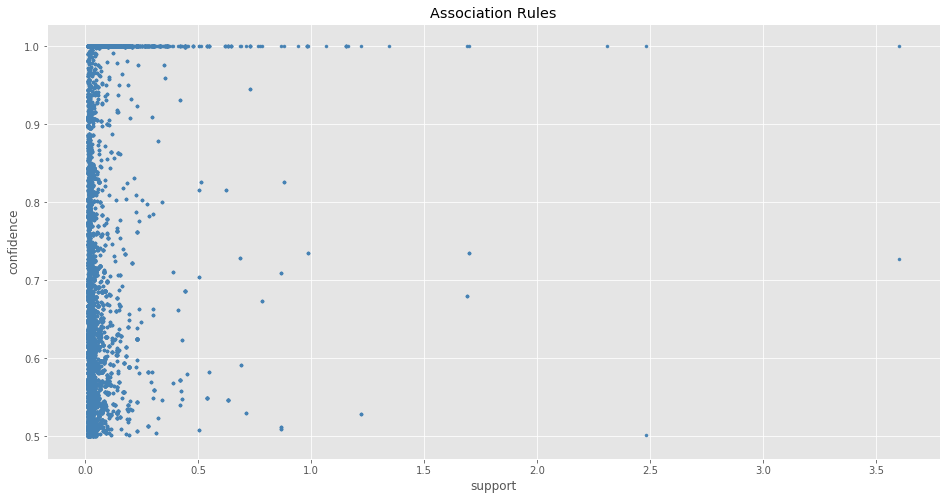

In [36]:
# 绘制support、confidence散点图
plt.figure(figsize=(16,8))
plt.style.use('ggplot')

plt.scatter(x=res['support'], y=res['confidence'], marker='.',color = 'steelblue')

plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')
plt.show()

结果分析：从散点图中可以看出，大部分关联规则的支持度分布在0到0.5之间，置信度分布在0.5到1之间。

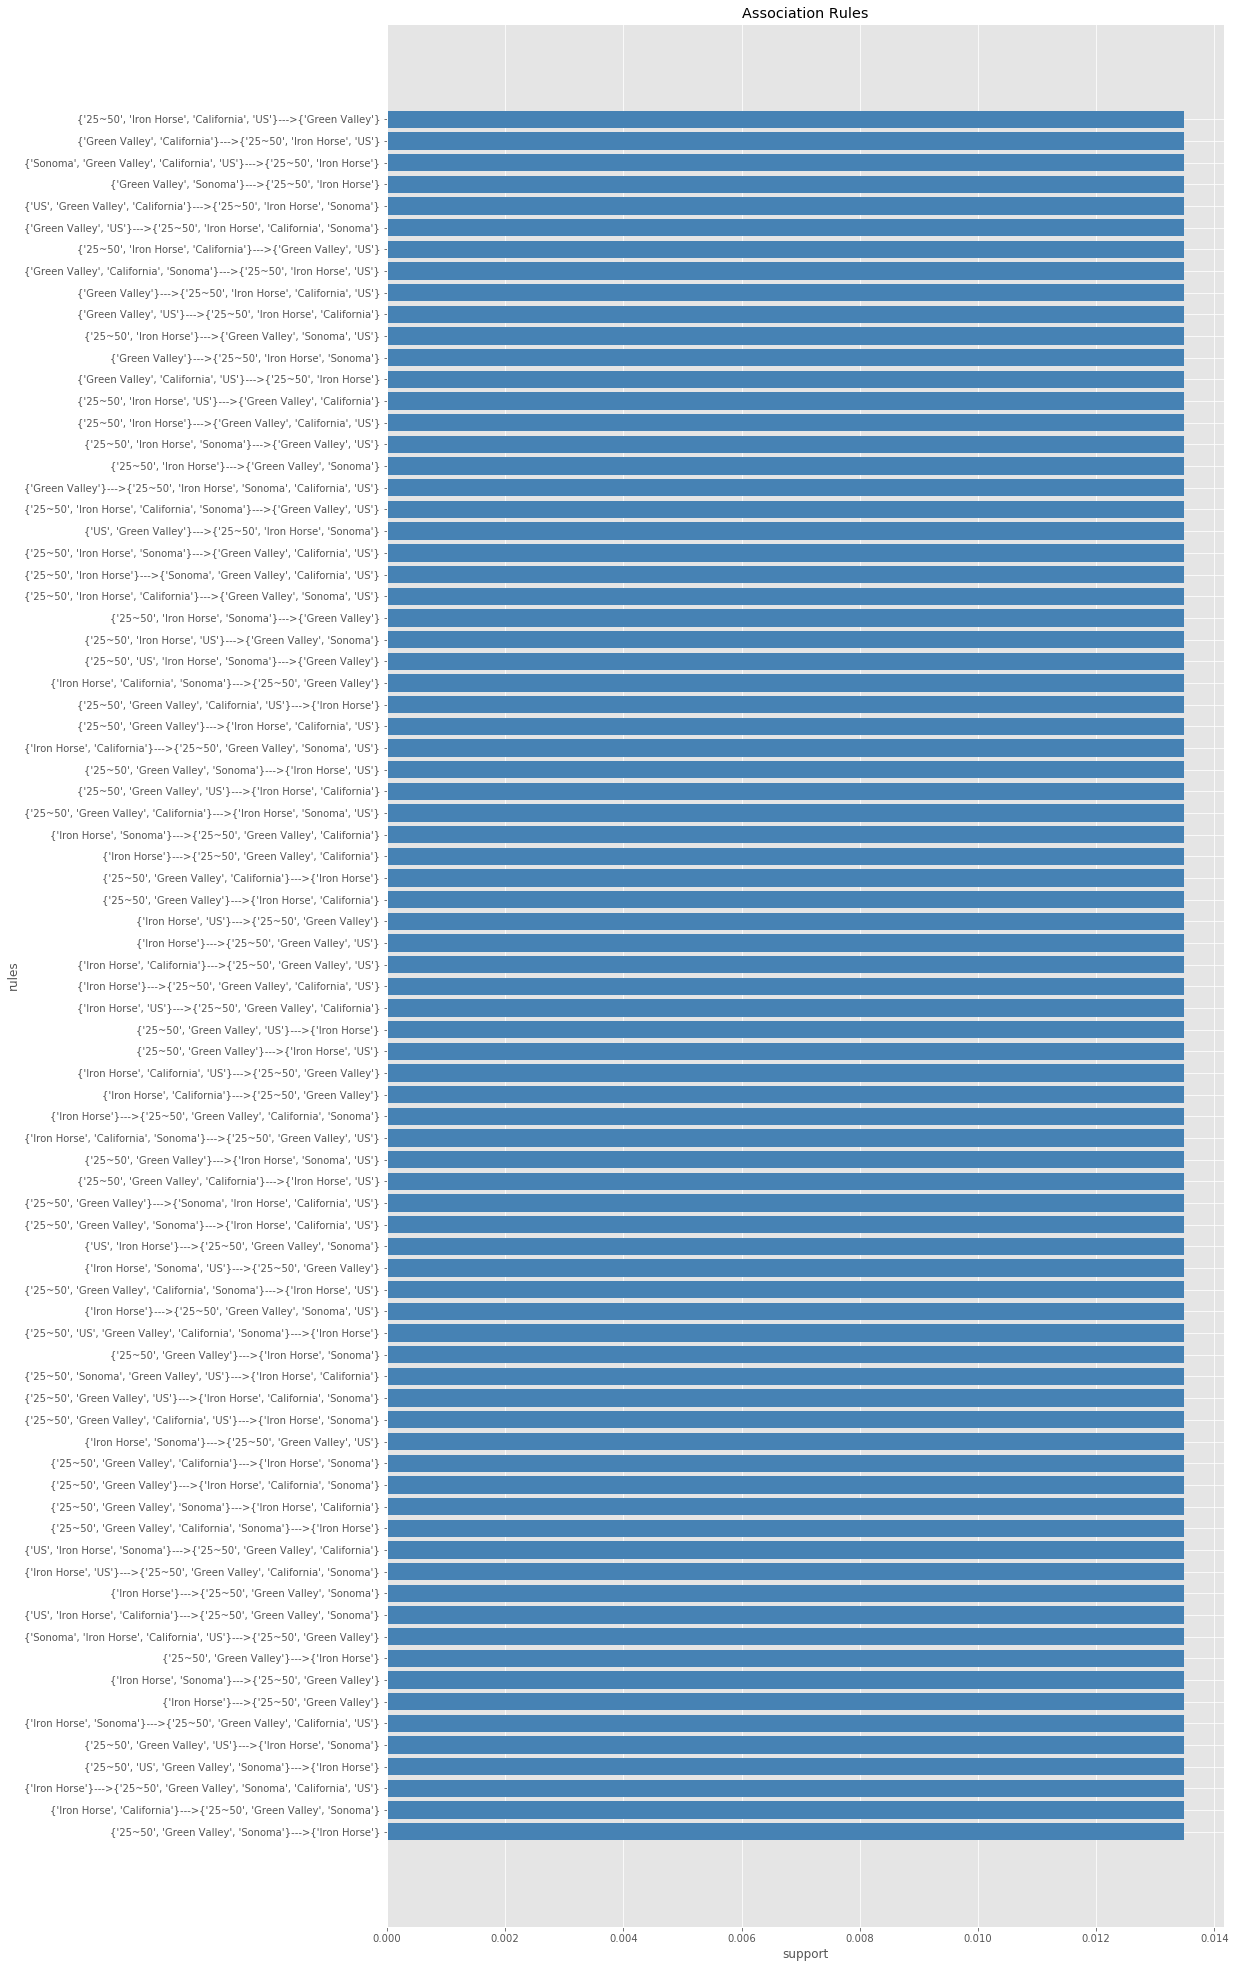

In [37]:
# 通过条形图来可视化关联规则的对应的支持度，选择排名靠前80进行展示
plt.figure(figsize=(15, 35))
plt.style.use('ggplot')

x = [i for i in range(80)]
y = res_sort.loc[:79, 'support'].tolist()
xticks = res_sort.loc[:79, 'rule'].tolist()
plt.yticks(x, xticks)
plt.barh(x, y, color = 'steelblue')

plt.title('Association Rules')
plt.ylabel('rules')
plt.xlabel('support')
plt.show()

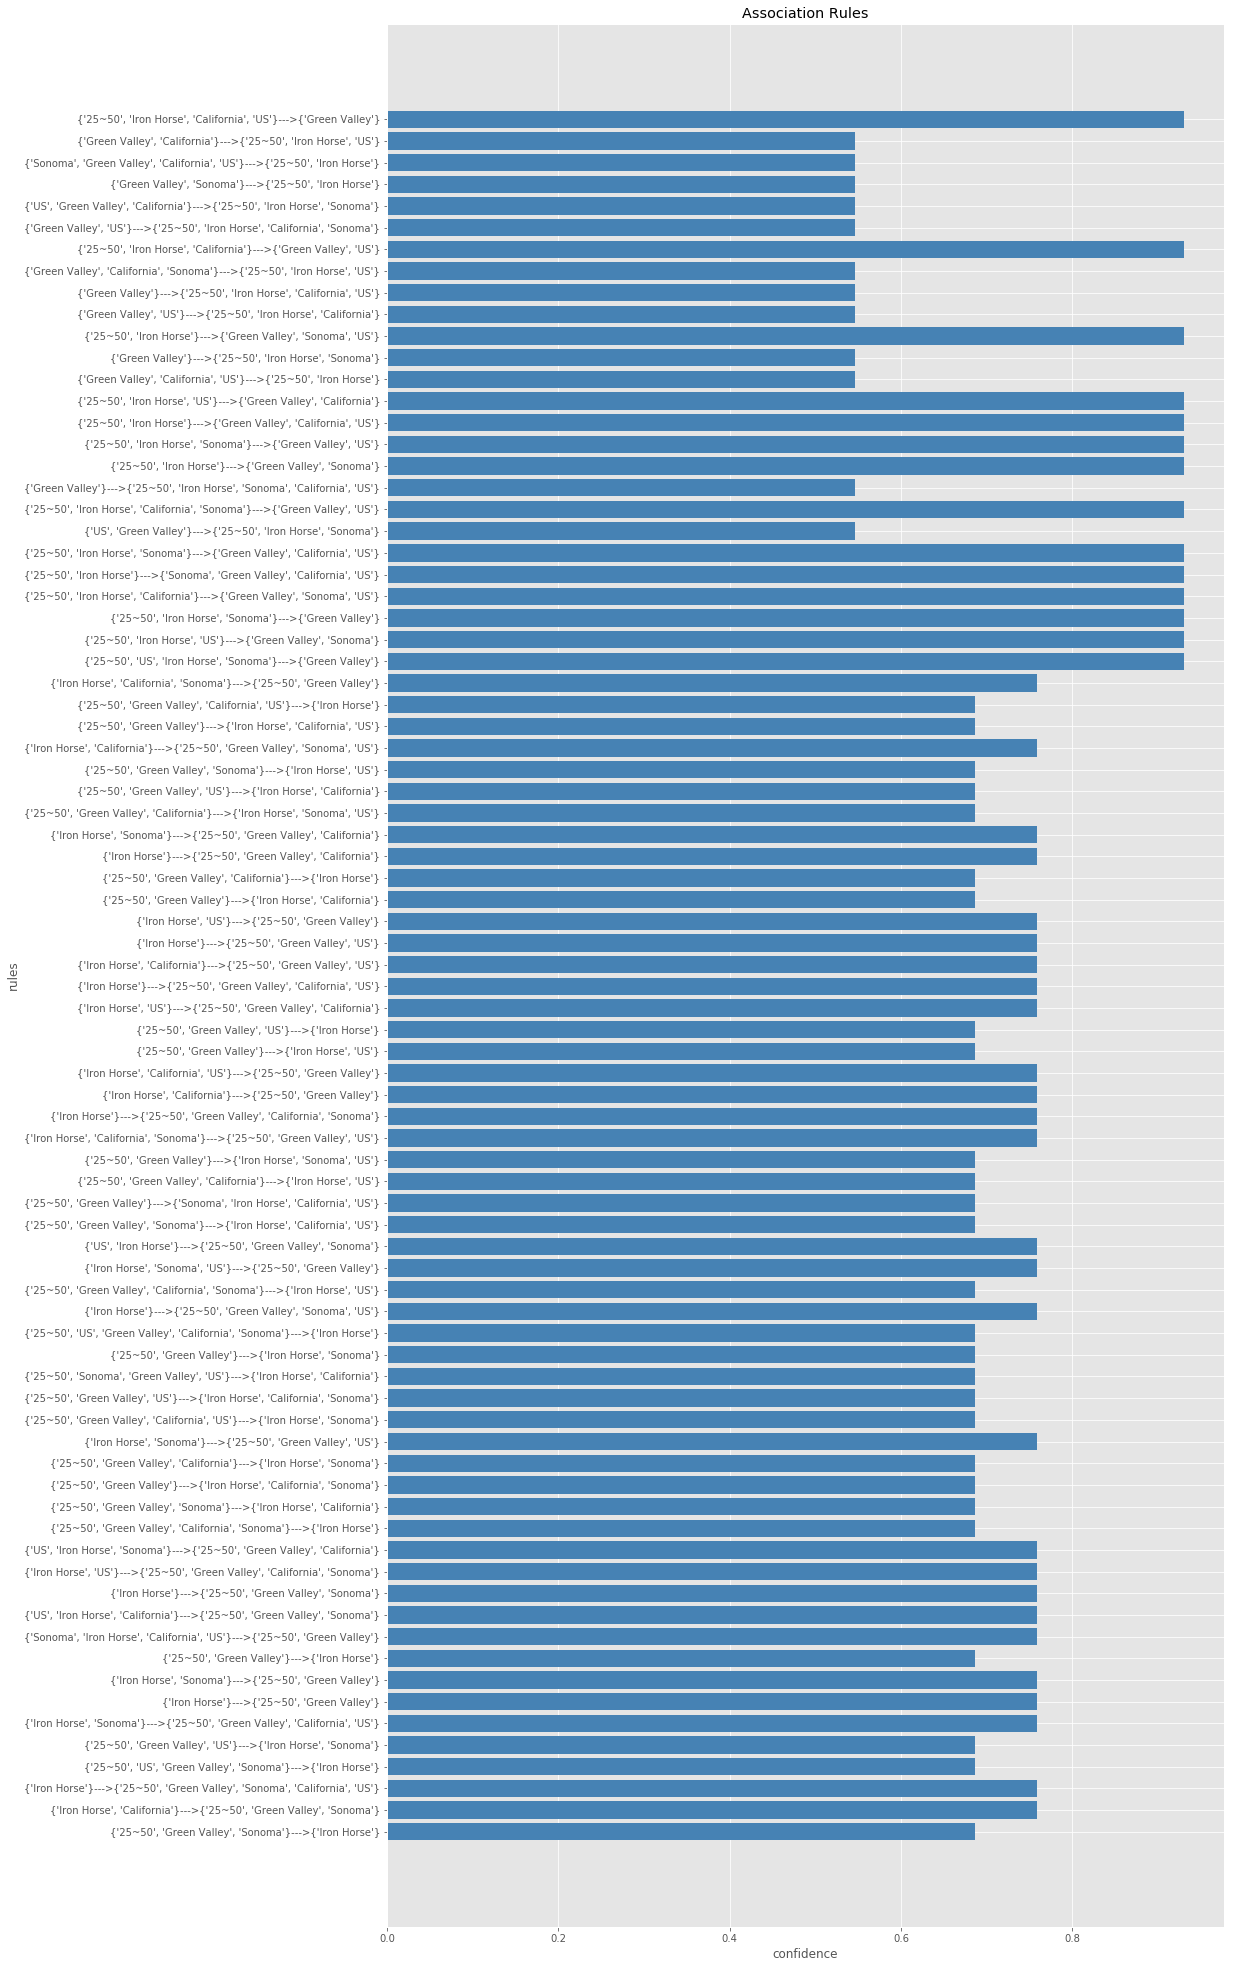

In [38]:
# 通过条形图来可视化关联规则的对应的置信度，选择排名靠前80进行展示
plt.figure(figsize=(15, 35))
plt.style.use('ggplot')

x = [i for i in range(80)]
y = res_sort.loc[:79, 'confidence'].tolist()
xticks = res_sort.loc[:79, 'rule'].tolist()
plt.yticks(x, xticks)
plt.barh(x, y, color = 'steelblue')

plt.title('Association Rules')
plt.ylabel('rules')
plt.xlabel('confidence')
plt.show()

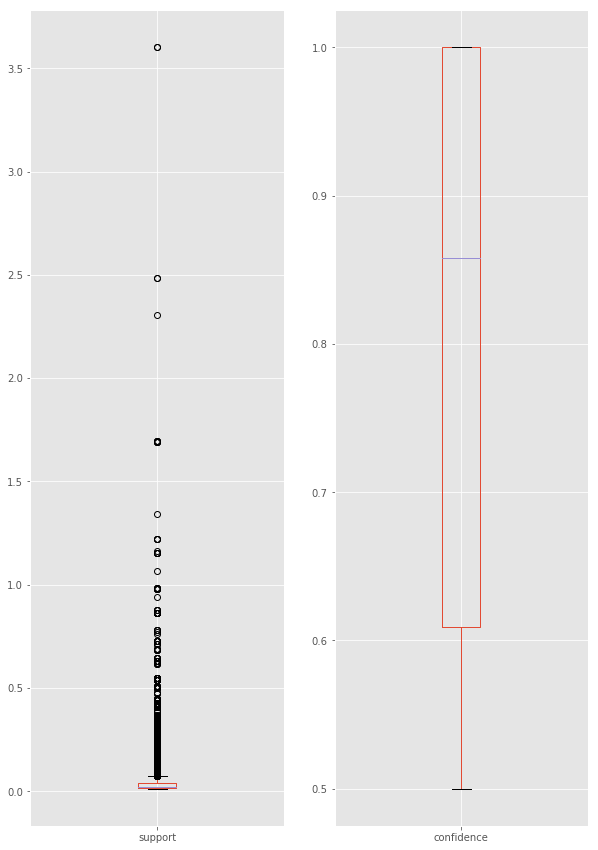

In [39]:
# 通过盒图查看关联规则的支持度、置信度分布情况
plt.subplot(1, 2, 1)
res["support"].plot.box(figsize=(10, 15))
plt.subplot(1, 2, 2)
res["confidence"].plot.box(figsize=(10, 15))
plt.show()

结果分析：通过盒图再次印证关联规则的支持度分布集中在0-0.5，置信度分布集中在0.5-1